In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect,Integer

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Let's see what we have in clases
inpector = inspect(engine)
columns = inpector.get_columns("measurement")
for c in columns:
    print(c["name"],c["type"])
    
columns = inpector.get_columns("station")
for c in columns:
    print(c["name"],c["type"])
# engine.execute("Select * From station").fetchall()
# engine.execute("Select * From measurement").fetchall()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0),
 (21, 'USC00519397', '2010-01-23', 0.0, 67.0),
 (22, 'USC00519397

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set..
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

Query Date:  2016-08-23


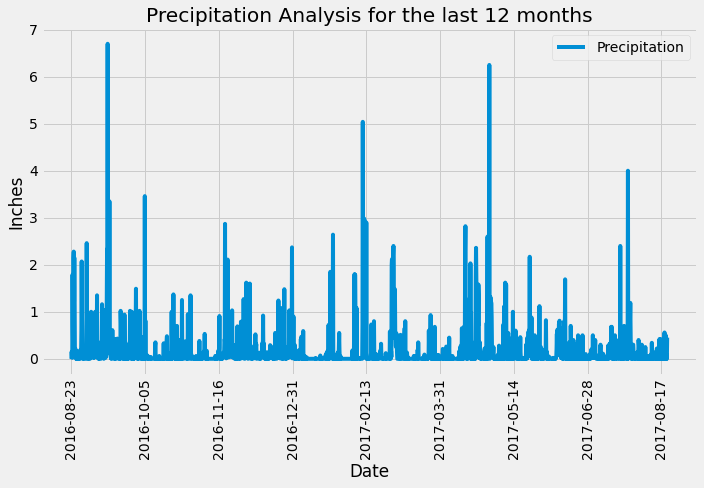

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# The latest date is 2017-08-23
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date, Measurement.prcp != None).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip, columns = ["Date", "Precipitation"])

# Sort the dataframe by date
precip_df = precip_df.sort_values(by=["Date"])
precip_df = precip_df.set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90, figsize = (10,7), ylabel = "Inches", title = "Precipitation Analysis for the last 12 months")
plt.tight_layout()
plt.savefig("Results/precipitation.png")
plt.show()


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()


9

In [30]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                         group_by(Measurement.station).\
                         order_by(func.count(Measurement.station).desc()).all()
for c in active_stations:
    print(f"sesion: {c[0]}, observations: {c[1]}")

sesion: USC00519281, observations: 2772
sesion: USC00519397, observations: 2724
sesion: USC00513117, observations: 2709
sesion: USC00519523, observations: 2669
sesion: USC00516128, observations: 2612
sesion: USC00514830, observations: 2202
sesion: USC00511918, observations: 1979
sesion: USC00517948, observations: 1372
sesion: USC00518838, observations: 511


In [58]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurement.tobs.cast(Integer))).\
               filter(Measurement.station == "USC00519281").all()

def convert_string(string):
    # Convert the temp to string
    lt = str(string[0])
    # Strip the string of parantheses and comma
    lt = lt.strip('(').strip(')').split(',')[0]
    # Converted to int
    lt = float(lt)
    return lt

print(f"the lowest temperature: {convert_string(lowest_temp)} F")

max_temp = session.query(func.max(Measurement.tobs.cast(Integer))).\
               filter(Measurement.station == "USC00519281").all()
print(f"the highest temperature: {convert_string(max_temp)} F")

avg_temp = session.query(func.avg(Measurement.tobs.cast(Integer))).\
               filter(Measurement.station == "USC00519281").all()
print(f"the average temperature: {round(convert_string(avg_temp),2)} F")

the lowest temperature: 54.0 F
the highest temperature: 85.0 F
the average temperature: 71.66 F


Query Date:  2016-08-23


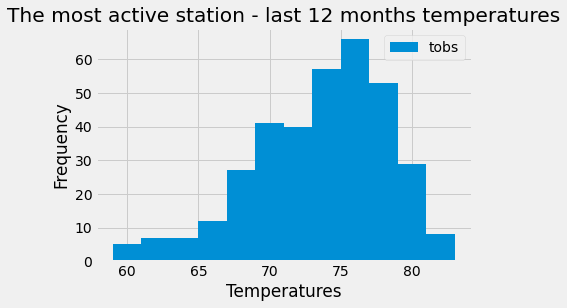

In [66]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)
temps = session.query(Measurement.tobs).\
    filter(Measurement.date >= query_date, Measurement.station == "USC00519281").\
    order_by(Measurement.tobs).all()

temps_df = pd.DataFrame(temps, columns = ["tobs"])
temps_df
bins = 12
temps_df.plot.hist(temps_df, bins)
plt.xlabel("Temperatures")
plt.title("The most active station - last 12 months temperatures")
plt.savefig("Results/most_active_station_temp.png")
plt.show()

# Close session

In [67]:
# Close Session
session.close()